In [88]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import Point

In [53]:
#smoke_raw = gpd.read_file("./input_data/hms_smoke20220503/hms_smoke20220503.shp")
smoke_raw = gpd.read_file("./input_data/hms_smoke20220831/hms_smoke20220831.shp")
smoke = smoke_raw.copy()
print(smoke.crs)
print(smoke.head())

epsg:4326
   Satellite         Start           End Density  \
0  GOES-EAST  2022243 1450  2022243 1450   Light   
1  GOES-WEST  2022243 1350  2022243 1520   Light   
2  GOES-WEST  2022243 1350  2022243 1520   Light   
3  GOES-EAST  2022243 2100  2022244 0010   Light   
4  GOES-EAST  2022243 2100  2022244 0010   Light   

                                            geometry  
0  POLYGON ((-97.10297 53.29824, -96.42085 52.530...  
1  POLYGON ((-119.43990 38.07075, -119.72067 38.1...  
2  POLYGON ((-119.31659 39.56018, -119.40600 39.2...  
3  POLYGON ((-96.99337 39.36360, -96.90487 39.418...  
4  POLYGON ((-97.22755 38.52546, -97.23365 38.552...  


In [54]:
# Load borders
counties_raw = gpd.read_file("./input_data/tl_2022_us_county/tl_2022_us_county.shp")
print(counties_raw.crs)
print(counties_raw.head())

epsg:4269
  STATEFP COUNTYFP  COUNTYNS  GEOID       NAME          NAMELSAD LSAD CLASSFP  \
0      31      039  00835841  31039     Cuming     Cuming County   06      H1   
1      53      069  01513275  53069  Wahkiakum  Wahkiakum County   06      H1   
2      35      011  00933054  35011    De Baca    De Baca County   06      H1   
3      31      109  00835876  31109  Lancaster  Lancaster County   06      H1   
4      31      129  00835886  31129   Nuckolls   Nuckolls County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND    AWATER     INTPTLAT  \
0  G4020  None   None     None        A  1477644346  10691216  +41.9158651   
1  G4020  None   None     None        A   680980770  61564427  +46.2946377   
2  G4020  None   None     None        A  6016818946  29090018  +34.3592729   
3  G4020  None   None     None        A  2169272978  22847034  +40.7835474   
4  G4020  None   None     None        A  1489645185   1718484  +40.1764918   

       INTPTLON                   

In [55]:
# Get only columns of interest
counties = counties_raw[["STATEFP", "COUNTYFP", "NAMELSAD", "geometry"]]
counties.reset_index(drop=True, inplace=True)

# See https://aqs.epa.gov/aqsweb/documents/codetables/states_and_counties.html
STATE_CODE = "'41'" # Oregon
COUNTY_CODE = "'039'" # Lane County, OR

counties["STATEFP"].unique()
#counties["COUNTYFP"] == "039"

county_query = f"`STATEFP` == {STATE_CODE}"
# Filter state and county
#lane_co = counties.query(f"`STATEFP` == {STATE_CODE} and `COUNTYFP` == {COUNTY_CODE}")
counties_filtered = counties.query(county_query)
counties.reset_index(drop=True, inplace=True)

counties_filtered.head()

# Convert to EPSG 4326
counties_filtered.to_crs(epsg=4326, inplace=True)
counties_filtered.crs


/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [70]:
# Clip smoke data to geographic region of interest
smoke_in_counties = smoke.clip(counties_filtered)
#print(smoke_in_counties)
print(smoke_in_counties["Density"].unique())

['Heavy' 'Medium' 'Light']


/usr/local/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [49]:
#smoke_filtered = smoke[smoke_intersect_counties]
#smoke_filtered.head()

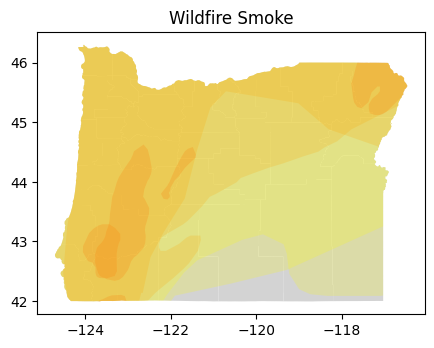

In [87]:
# Set up color palette for smoke data
smoke_pal = {
    "Heavy": "Red",
    "Medium": "Orange",
    "Light": "Yellow"}

# Plot points against outline of Wisconsin
fig, ax = plt.subplots(figsize = (5,5))
counties_filtered.plot(ax=ax, color='lightgrey')
#smoke_in_counties.plot(ax=ax, alpha=0.1)

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in smoke_in_counties.groupby("Density"):
    # Define the color for each group using the dictionary
    color = smoke_pal[ctype]
    # Plot each group using the color defined above
    data.plot(
        color=color,
        ax=ax,
        label=ctype,
        alpha=0.2)

#ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})

ax.set_title('Wildfire Smoke')
#ax.set_axis_off()

plt.show()

In [95]:
# Get point for examining smoke data
start_x = -123.083823
start_y = 44.026281
start_point = Point(start_x, start_y)
start_gdf = gpd.GeoDataFrame({"name": ["start"], "geometry": [start_point]}, crs=4326)
start_gdf.to_crs(2992, inplace=True) # Convert to Oregon Lambert https://www.oregon.gov/geo/pages/projections.aspx

In [96]:
# Create concentric buffers of 5 miles, 25 miles, and 100 miles
buf_1 = start_gdf.buffer(5 * 5280)
buf_2 = start_gdf.buffer(25 * 5280)
buf_3 = start_gdf.buffer(100 * 5280)

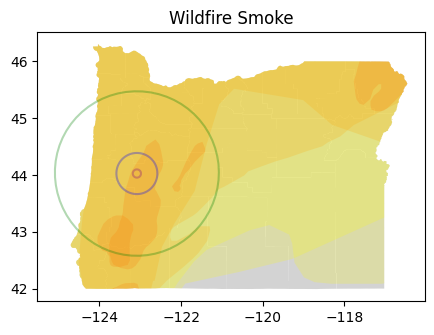

In [109]:
# Set up color palette for smoke data
smoke_pal = {
    "Heavy": "Red",
    "Medium": "Orange",
    "Light": "Yellow"}

# Plot points against outline of Wisconsin
fig, ax = plt.subplots(figsize = (5,5))
counties_filtered.plot(ax=ax, color='lightgrey')
#smoke_in_counties.plot(ax=ax, alpha=0.1)

# Loop through each attribute type and plot it using the colors assigned in the dictionary
for ctype, data in smoke_in_counties.groupby("Density"):
    # Define the color for each group using the dictionary
    color = smoke_pal[ctype]
    # Plot each group using the color defined above
    data.plot(
        color=color,
        ax=ax,
        label=ctype,
        alpha=0.2)

buf_3.boundary.to_crs(4326).plot(
    color = "green",
    ax=ax,
    alpha = 0.3)

buf_2.boundary.to_crs(4326).plot(
    color = "blue",
    ax=ax,
    alpha = 0.3)

buf_1.boundary.to_crs(4326).plot(
    color = "purple",
    ax=ax,
    alpha = 0.3)
#ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})

ax.set_title('Wildfire Smoke')
#ax.set_axis_off()

plt.show()